In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from scipy import stats
from functools import partial
import seaborn as sns

In [2]:
def gumbel_loss(diff, beta):
    z = diff/beta
    loss = torch.exp(z) - z - 1 
    return loss

def gumbel_stable_loss(diff, beta, clip=None):
    z = diff/beta
    if clip is not None:
        z = torch.clamp(z, max=clip)
    max_z = torch.max(z)
    max_z = torch.where(max_z < -1.0, torch.tensor(-1.0, dtype=torch.double, device=max_z.device), max_z)
    max_z = max_z.detach() # Detach the gradients
    loss = torch.exp(z - max_z) - z*torch.exp(-max_z) - torch.exp(-max_z)    # scale by e^max_z
    return loss

In [3]:
def gumbel_fit(data, betas, lr=0.01, steps=100, times=10, stable=False, min=False):
    if not stable:
      loss_fn = gumbel_loss
    else: 
      loss_fn = gumbel_stable_loss

    out = []
    for beta in betas:
        solves = []
        opt = log_partition(data, beta)
        # We estimate the log-partition function 10 times to calculate the mean and std of the estimations
        for times in range(times):
            expectile = solver_1d(data, partial(loss_fn, beta=beta), lr=lr, steps=steps)
            solves.append(expectile[0])
            # print(solves)
        solves = np.array(solves)
        print(f"Temperature {beta}, Estimated log-partition: {solves.mean()}, True: {opt}")
        diff = solves - opt
        print(f"Estimation error: Mean: {diff.mean()}, Std: {diff.std()}\n\n")
        out.append([solves.mean(), opt])

    return out


In [9]:
from scipy.special import logsumexp

def log_partition(x, beta):
    """Analytically calculate the Log-Partition over an emperical distribution 
    """
    n = x.shape[0]
    return beta * logsumexp(x/beta) - beta * np.log(n)

def solver_1d(data, loss_fn, lr=0.005, batch=128, steps=4000):
    """ Estimate Log-Partition function using Gumbel loss with SGD
    """
    if isinstance(data, np.ndarray):
        data = torch.from_numpy(data)
    statistic = torch.zeros(1, requires_grad=True)
    optim = torch.optim.Adam([statistic], lr=lr)
    for _ in range(steps):
        # Sample a batch
        perm = torch.randperm(data.size(0))
        idx = perm[:batch]
        samples = data[idx]

        optim.zero_grad()
        loss = torch.mean(loss_fn(samples-statistic))
        loss.backward()
        optim.step()
    return statistic.detach().cpu().numpy()

def analytic_logpartition(beta, C):
  Z = 1/2 * 1/np.sinh(C * beta/2)
  return np.log(Z)

In [10]:
k_b = 1.380649 * 1.e-23

C = (1.e-20)/k_b

In [8]:
lr = 1e-2
steps = 5000

temps = range(1, 400, 20)
betas = [1/T for T in temps]

N = 10000

preds, actuals = [], []

for beta in betas:
  data = np.array([-(n + 1/2) * C * beta for n in range(0, N)])
  # print(data[:20])

  out = gumbel_fit(data, [1], lr, steps, times=5, stable=False)
  pred, gt = out[0]

  preds.append(pred)
  actuals.append(gt)

Temperature 1, Estimated log-partition: -49.997615814208984, True: -371.35886617397216
Estimation error: Mean: 321.3612365722656, Std: 0.0


Temperature 1, Estimated log-partition: -26.64498519897461, True: -26.455508267309323
Estimation error: Mean: -0.1894764006137848, Std: 0.28592726588249207


Temperature 1, Estimated log-partition: -18.086082458496094, True: -18.04323122392163
Estimation error: Mean: -0.04285125806927681, Std: 0.09538759291172028


Temperature 1, Estimated log-partition: -15.134950637817383, True: -15.147194479465991
Estimation error: Mean: 0.012243842706084251, Std: 0.16993598639965057


Temperature 1, Estimated log-partition: -13.913981437683105, True: -13.681179030558694
Estimation error: Mean: -0.2328025847673416, Std: 0.21839213371276855


Temperature 1, Estimated log-partition: -12.85058879852295, True: -12.795200689395951
Estimation error: Mean: -0.05538826063275337, Std: 0.18392667174339294


Temperature 1, Estimated log-partition: -12.397920608520508, Tru

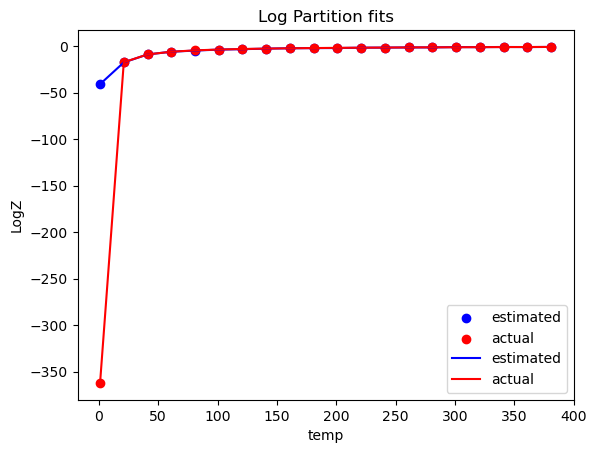

In [54]:
analytic = np.array([analytic_logpartition(beta, C) for beta in betas])

def temperature_plot(temps, preds, actuals, N, nn_temps=None, nn_preds=None):
    plt.scatter(temps, preds + np.log(N), label=f"estimated", color = 'blue')
    plt.scatter(temps, actuals + np.log(N), label=f"actual", color = 'red')

    plt.plot(temps, preds + np.log(N), label=f"estimated", color = 'blue')
    plt.plot(temps, actuals + np.log(N), label=f"actual", color = 'red')
    
    if nn_temps is not None:
        assert nn_temps.shape == nn_preds.shape, "NN temperatures and preds must be of the same shape"
        plt.plot(nn_temps, nn_preds.detach() + np.log(N), label=f"NN model", color='green')
        
    # plt.plot(temps, analytic, label=f"analytic", color = 'green')

    plt.title("Log Partition fits")
    plt.xlabel("temp")
    plt.ylabel("LogZ")
    plt.legend()
    plt.show()

temperature_plot(temps, preds, actuals, N)

In [67]:
import torch.nn as nn
import torch.nn.functional as F

class ReluModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1)

    def forward(self, x):
        return self.fc3(F.relu(self.fc2(F.relu(self.fc1(x)))))

Iteration 0 loss:  tensor(7816.8906, grad_fn=<MeanBackward0>)
Iteration 100 loss:  tensor(69.1464, grad_fn=<MeanBackward0>)
Iteration 200 loss:  tensor(13413.2578, grad_fn=<MeanBackward0>)
Iteration 300 loss:  tensor(12921.0225, grad_fn=<MeanBackward0>)
Iteration 400 loss:  tensor(12327.3721, grad_fn=<MeanBackward0>)
Iteration 500 loss:  tensor(11482.6777, grad_fn=<MeanBackward0>)
Iteration 600 loss:  tensor(10494.6279, grad_fn=<MeanBackward0>)
Iteration 700 loss:  tensor(34.5540, grad_fn=<MeanBackward0>)
Iteration 800 loss:  tensor(145.7148, grad_fn=<MeanBackward0>)
Iteration 900 loss:  tensor(85.3014, grad_fn=<MeanBackward0>)
Iteration 1000 loss:  tensor(83.7557, grad_fn=<MeanBackward0>)
Iteration 1100 loss:  tensor(5837.3599, grad_fn=<MeanBackward0>)
Iteration 1200 loss:  tensor(4864.5615, grad_fn=<MeanBackward0>)
Iteration 1300 loss:  tensor(4055.0269, grad_fn=<MeanBackward0>)
Iteration 1400 loss:  tensor(332.1575, grad_fn=<MeanBackward0>)
Iteration 1500 loss:  tensor(2164.6450, gr

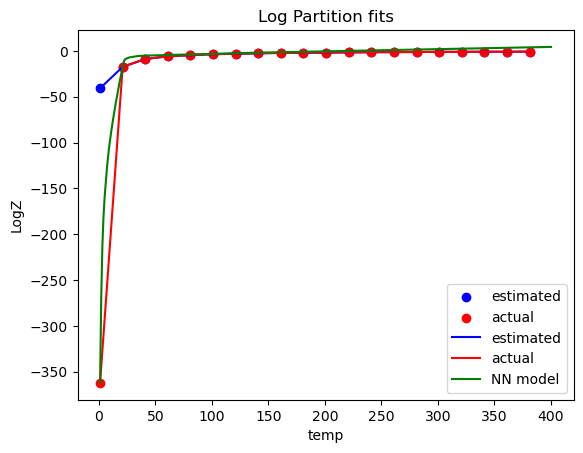

In [69]:
model = ReluModel()
model_lr = 1e-4

optimizer = torch.optim.AdamW(model.parameters(), lr=model_lr)
loss = torch.nn.MSELoss()
max_iter = 5000
temps = torch.Tensor(temps)
actuals = torch.Tensor(actuals)
batch_size = 10
for iter_ in range(max_iter):
    # sample batch
    if iter_ % 100 == 0:
        print(f"Iteration {iter_} loss: ", loss_value)
    perm = torch.randperm(temps.size(0))
    idx = perm[:batch_size]
    samples = temps[idx].reshape(batch_size, 1)
    optimizer.zero_grad()
    pred_logZ = model(samples)
    loss_value = torch.mean(loss(pred_logZ.reshape(-1), actuals[idx].reshape(-1)))
    loss_value.backward()

    optimizer.step()

Ts = torch.linspace(1, 400, 400).reshape(-1, 1)
temperature_plot(temps, preds, actuals, N, nn_temps=Ts, nn_preds=model(Ts))

In [17]:
Ts = torch.Tensor(temps)

In [18]:
Ts

tensor([  1.,  21.,  41.,  61.,  81., 101., 121., 141., 161., 181., 201., 221.,
        241., 261., 281., 301., 321., 341., 361., 381.])

In [37]:
idx

tensor([13, 19, 15, 17, 10])

In [38]:
actuals

[-371.35886617397216,
 -26.455508267309323,
 -18.04323122392163,
 -15.147194479465991,
 -13.681179030558694,
 -12.795200689395951,
 -12.200786345352906,
 -11.772876180204882,
 -11.448524765410177,
 -11.192706103994235,
 -10.984467618357264,
 -10.81056373148769,
 -10.662243363831273,
 -10.53351025847338,
 -10.420126984600987,
 -10.31901828866316,
 -10.22789986582696,
 -10.145039772545712,
 -10.069100697212527,
 -9.999033056810749]

In [39]:
actuals[idx]

TypeError: only integer tensors of a single element can be converted to an index

In [40]:
torch.Tensor(actuals)[idx]

tensor([-10.5335,  -9.9990, -10.3190, -10.1450, -10.9845])